In [1]:
import json
import requests
from keras.models import Sequential
from keras.layers import Activation, Dense, Dropout, LSTM
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.metrics import mean_absolute_error
%matplotlib inline

In [2]:
endpoint = 'https://min-api.cryptocompare.com/data/histoday'
res = requests.get(endpoint + '?fsym=ADA&tsym=USD&limit=700')
df = pd.DataFrame(json.loads(res.content)['Data'])
df = df.set_index('time')
df.index = pd.to_datetime(df.index, unit='s')
target_col='close'

In [3]:
df

,high,low,open,volumefrom,volumeto,close,conversionType,conversionSymbol
time,,,,,,,,
2019-11-26,0.03860,0.03575,0.03607,3236813.40,118318.27,0.03821,direct,
2019-11-27,0.04005,0.03558,0.03821,13355448.26,521006.11,0.03910,direct,
2019-11-28,0.04112,0.03850,0.03910,3577803.53,140061.56,0.03947,direct,
2019-11-29,0.04308,0.03938,0.03947,8877647.93,365415.92,0.04136,direct,
2019-11-30,0.04299,0.04005,0.04136,4829896.44,197042.17,0.04085,direct,
...,...,...,...,...,...,...,...,...
2021-10-22,2.20900,2.12700,2.13800,35134372.96,76115084.32,2.15500,direct,
2021-10-23,2.17300,2.13400,2.15500,17003014.14,36623023.17,2.16500,direct,
2021-10-24,2.16700,2.09500,2.16500,21736670.71,46230772.98,2.12000,direct,


In [4]:
df = df.drop(['conversionType','conversionSymbol'], axis=1)
df

,high,low,open,volumefrom,volumeto,close
time,,,,,,
2019-11-26,0.03860,0.03575,0.03607,3236813.40,118318.27,0.03821
2019-11-27,0.04005,0.03558,0.03821,13355448.26,521006.11,0.03910
2019-11-28,0.04112,0.03850,0.03910,3577803.53,140061.56,0.03947
2019-11-29,0.04308,0.03938,0.03947,8877647.93,365415.92,0.04136
2019-11-30,0.04299,0.04005,0.04136,4829896.44,197042.17,0.04085
...,...,...,...,...,...,...
2021-10-22,2.20900,2.12700,2.13800,35134372.96,76115084.32,2.15500
2021-10-23,2.17300,2.13400,2.15500,17003014.14,36623023.17,2.16500
2021-10-24,2.16700,2.09500,2.16500,21736670.71,46230772.98,2.12000


In [5]:
def line_plot(line1, line2, label1=None, label2=None, title='', lw=2):
    fig, ax = plt.subplots(1, figsize=(13, 7))
    ax.plot(line1, label=label1, linewidth=lw)
    ax.plot(line2, label=label2, linewidth=lw)
    ax.set_ylabel('price [CAD]', fontsize=14)
    ax.set_title(title, fontsize=16)
    ax.legend(loc='best', fontsize=16);

In [6]:
def train_test_split(df, test_size=0.4):
    split_row = len(df) - int(test_size * len(df))
    train_data = df.iloc[:split_row]
    test_data = df.iloc[split_row:]
    return train_data, test_data

In [7]:
train, test = train_test_split(df,test_size=0.4)

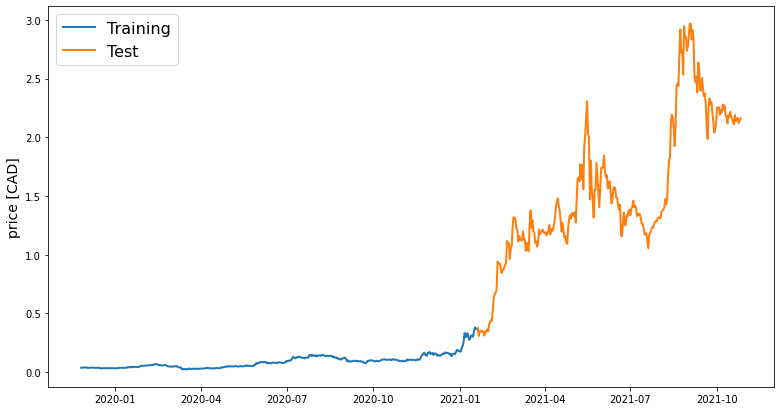

In [8]:
line_plot(train[target_col], test[target_col], 'Training', 'Test', title='')

In [9]:
print(train)
print(test)

               high      low     open    volumefrom     volumeto    close
time                                                                     
2019-11-26  0.03860  0.03575  0.03607  3.236813e+06    118318.27  0.03821
2019-11-27  0.04005  0.03558  0.03821  1.335545e+07    521006.11  0.03910
2019-11-28  0.04112  0.03850  0.03910  3.577804e+06    140061.56  0.03947
2019-11-29  0.04308  0.03938  0.03947  8.877648e+06    365415.92  0.04136
2019-11-30  0.04299  0.04005  0.04136  4.829896e+06    197042.17  0.04085
...             ...      ...      ...           ...          ...      ...
2021-01-15  0.33110  0.27750  0.31100  1.307441e+08  40231461.68  0.30270
2021-01-16  0.36680  0.30210  0.30270  1.683773e+08  57646426.87  0.35110
2021-01-17  0.39740  0.34150  0.35110  1.889311e+08  70590866.80  0.38150
2021-01-18  0.39680  0.36430  0.38150  9.642112e+07  36173045.45  0.37090
2021-01-19  0.38480  0.36280  0.37090  8.180933e+07  30468473.23  0.36810

[421 rows x 6 columns]
              

In [10]:
def normalise_zero_base(df):
    return df / df.iloc[0] - 1

def normalise_min_max(df):
    return (df - df.min()) / (data.max() - df.min())

In [11]:
def extract_window_data(df, window_len=5, zero_base=True):
    window_data = []
    for idx in range(len(df) - window_len):
        tmp = df[idx: (idx + window_len)].copy()
        if zero_base:
            tmp = normalise_zero_base(tmp)
        window_data.append(tmp.values)
    return np.array(window_data)

In [12]:
def prepare_data(df, target_col, window_len=5, zero_base=True, test_size=0.4):
    train_data, test_data = train_test_split(df, test_size=test_size)
    X_train = extract_window_data(train_data, window_len, zero_base)
    X_test = extract_window_data(test_data, window_len, zero_base)
    y_train = train_data[target_col][window_len:].values
    y_test = test_data[target_col][window_len:].values
    if zero_base:
        y_train = y_train / train_data[target_col][:-window_len].values - 1
        y_test = y_test / test_data[target_col][:-window_len].values - 1

    return train_data, test_data, X_train, X_test, y_train, y_test

In [35]:
def build_lstm_model(input_data, output_size, neurons=120, activ_func='linear',
                     dropout=0.3, loss='mse', optimizer='adam'):
    model = Sequential()
    model.add(LSTM(neurons, input_shape=(input_data.shape[1], input_data.shape[2])))
    model.add(Dropout(dropout))
    model.add(Dense(units=output_size))
    model.add(Activation(activ_func))

    model.compile(loss=loss, optimizer=optimizer)
    return model

In [36]:
np.random.seed(42)
window_len = 5
test_size = 0.4
zero_base = True
lstm_neurons = 120
epochs = 40
batch_size = 32
loss = 'mse'
dropout = 0.3
optimizer = 'adam'

In [37]:
train, test, X_train, X_test, y_train, y_test = prepare_data(df, target_col, window_len=window_len, zero_base=zero_base, test_size=test_size)

In [38]:
from keras.callbacks import EarlyStopping
es = EarlyStopping(mode='min',verbose=1,patience=5)

In [39]:
model = build_lstm_model( X_train, output_size=1, neurons=lstm_neurons, dropout=dropout, loss=loss, optimizer=optimizer)
history = model.fit( X_train, y_train, epochs=epochs, batch_size=batch_size, validation_split=0.3, validation_data=(X_test,y_test), verbose=1, shuffle=True, callbacks = [es])

Epoch 1/40
10/10 [==============================] - 2s 59ms/step - loss: 0.0226 - val_loss: 0.0206
Epoch 2/40
10/10 [==============================] - 0s 12ms/step - loss: 0.0127 - val_loss: 0.0177
Epoch 3/40
10/10 [==============================] - 0s 12ms/step - loss: 0.0096 - val_loss: 0.0116
Epoch 4/40
10/10 [==============================] - 0s 13ms/step - loss: 0.0093 - val_loss: 0.0109
Epoch 5/40
10/10 [==============================] - 0s 11ms/step - loss: 0.0087 - val_loss: 0.0109
Epoch 6/40
10/10 [==============================] - 0s 12ms/step - loss: 0.0085 - val_loss: 0.0095
Epoch 7/40
10/10 [==============================] - 0s 10ms/step - loss: 0.0075 - val_loss: 0.0098
Epoch 8/40
10/10 [==============================] - 0s 12ms/step - loss: 0.0071 - val_loss: 0.0091
Epoch 9/40
10/10 [==============================] - 0s 11ms/step - loss: 0.0064 - val_loss: 0.0095
Epoch 10/40
10/10 [==============================] - 0s 9ms/step - loss: 0.0062 - val_loss: 0.0094
Epoch 11/4

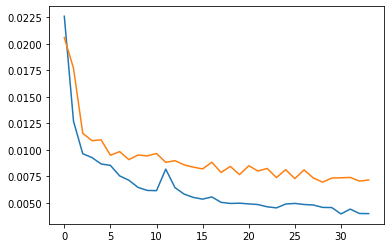

In [40]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

In [42]:
targets = test[target_col][window_len:]
preds = model.predict(X_test).squeeze()
mean_absolute_error(preds, y_test)

0.055325795378141085

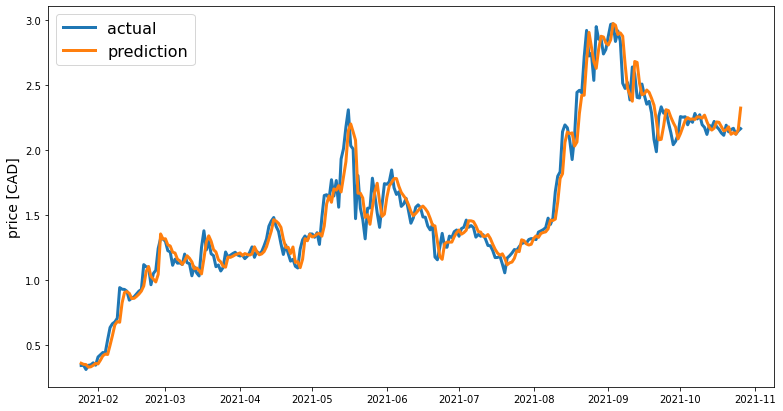

In [43]:
preds = test[target_col].values[:-window_len] * (preds + 1)
preds = pd.Series(index=targets.index, data=preds)
line_plot(targets, preds, 'actual', 'prediction', lw=3)

In [44]:
model.save('ADAmodel.hdf5')